In [1]:
import numpy as np

# Euler Angles and Rotation Matrix
- Direct problem: euler -> rotm
- Inverse problem: rotm -> euler

![EULER-ANGLES-RPY](images/roll-pitch-yaw.jpg)

In [2]:
# Calculates Rotation Matrix given euler angles in the order of YAW(psi), PITCH(theta), ROLL(phi)
def eulerAnglesToRotationMatrix(theta):
    '''
    :param: theta: np array 
        array of angles (radians) in the order of YAW(psi), PITCH(theta), ROLL(phi)

    YAW = rotation around the x axis
    PITCH = rotation around the y axis
    ROLL = rotation around the z axis

    :return: 3 by 3 np array
        Return 3x3 rotation matrix
    '''
    #yaw rotation
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         np.cos(theta[0]), -np.sin(theta[0]) ],
                    [0,         np.sin(theta[0]), np.cos(theta[0])  ]
                    ])
    #pitch rotation
    R_y = np.array([[np.cos(theta[1]),    0,      np.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]
                    ])
    #roll rotation
    R_z = np.array([[np.cos(theta[2]),    -np.sin(theta[2]),    0],
                    [np.sin(theta[2]),    np.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])

    R = np.dot(R_z, np.dot( R_y, R_x ))

    return R


In [3]:
angles_1 = np.array([0, 45, 90]) * (np.pi/180)
print(angles_1)

[0.         0.78539816 1.57079633]


In [4]:
R = eulerAnglesToRotationMatrix(angles_1)
print(R)

[[ 4.32978028e-17 -1.00000000e+00  4.32978028e-17]
 [ 7.07106781e-01  6.12323400e-17  7.07106781e-01]
 [-7.07106781e-01  0.00000000e+00  7.07106781e-01]]


In [33]:
def isRotationMatrix(R, precision = 1e-4):
    """
    Checks if a matrix is a rotation matrix
    :param R: np.array matrix of 3 by 3
    :param precision: float
        precision to respect to accept a zero value in identity matrix check (default is 1e-4)
    :return: True or False
        Return True if a matrix is a rotation matrix, False if not
    """
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype=R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < precision

def rotationMatrixToEulerAngles(R, precision = 1e-4):
    """
    Computes the Tait–Bryan Euler () angles from a Rotation Matrix.
    Also checks if there is a gymbal lock and eventually use an alternative formula
    :param R: np.array
        3 x 3 Rotation matrix
    :param precision: float
        precision to respect to accept a zero value in identity matrix check (default is 1e-4)
    :return: (yaw, pitch, roll) tuple of float numbers
        Euler angles in radians in the order of YAW, PITCH, ROLL
    """
    # Calculates Tait–Bryan Euler angles from a Rotation Matrix
    assert (isRotationMatrix(R, precision))  # check if it's a Rmat

    sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0]) # assert that sqrt(R11^2 + R21^2) != 0
    singular = sy < precision

    if not singular:  #if not in a singularity, use the standard formula
        x = np.arctan2(R[2, 1], R[2, 2])  # atan2(R31, R33) -> YAW, angle psi
        
        # atan2(-R31, sqrt(R11^2 + R21^2)) -> PITCH, angle delta
        y = np.arctan2(-R[2, 0], sy)

        z = np.arctan2(R[1, 0], R[0, 0]) #atan2(R21,R11) -> ROLL, angle phi

    else:  # if in gymbal lock, use different formula for yaw, pitch roll
        x = np.arctan2(-R[1, 2], R[1, 1])
        y = np.arctan2(-R[2, 0], sy)
        z = 0

    return np.array([x, y, z]) # returns YAW, PITCH, ROLL


In [34]:
angles = rotationMatrixToEulerAngles(R) * 180/np.pi
print(f"YAW:{angles[0]}\nPITCH:{angles[1]}\nROLL:{angles[2]}")

YAW:0.0
PITCH:45.0
ROLL:90.0


In [35]:
#let's try a singularity point where pitch = 90°
sing_angl = np.array([45,90,45]) * np.pi/180
R_sing = eulerAnglesToRotationMatrix(sing_angl)
print(R_sing)
rev_angl = rotationMatrixToEulerAngles(R_sing) * 180/np.pi
print(f"YAW:{rev_angl[0]}\nPITCH:{rev_angl[1]}\nROLL:{rev_angl[2]}")


[[ 4.32978028e-17  0.00000000e+00  1.00000000e+00]
 [ 4.32978028e-17  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  4.32978028e-17  4.32978028e-17]]
YAW:-0.0
PITCH:90.0
ROLL:0.0


# Hand Tracking with the Mediapipe Library

In [3]:
import mediapipe as mp
import cv2
import numpy as np
import HandTrackingModule as htm
import matplotlib.pyplot as plt

cv2.setUseOptimized(True)


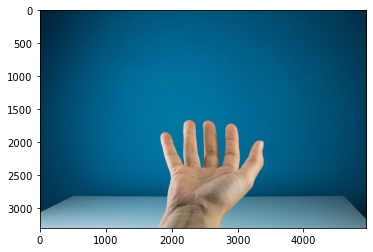

In [4]:
img = cv2.imread("images/hand_image.jpg", 1)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)


In [5]:
detector = htm.HandDetector(mode=True)

[[0, 2388, 2948], [1, 2856, 2775], [2, 3118, 2593], [3, 3267, 2303], [4, 3310, 2047], [5, 2833, 2477], [6, 2887, 2183], [7, 2892, 1992], [8, 2883, 1820], [9, 2575, 2463], [10, 2584, 2180], [11, 2582, 1956], [12, 2594, 1767], [13, 2344, 2468], [14, 2308, 2180], [15, 2289, 1960], [16, 2303, 1762], [17, 2111, 2515], [18, 2009, 2280], [19, 1938, 2097], [20, 1899, 1927]]


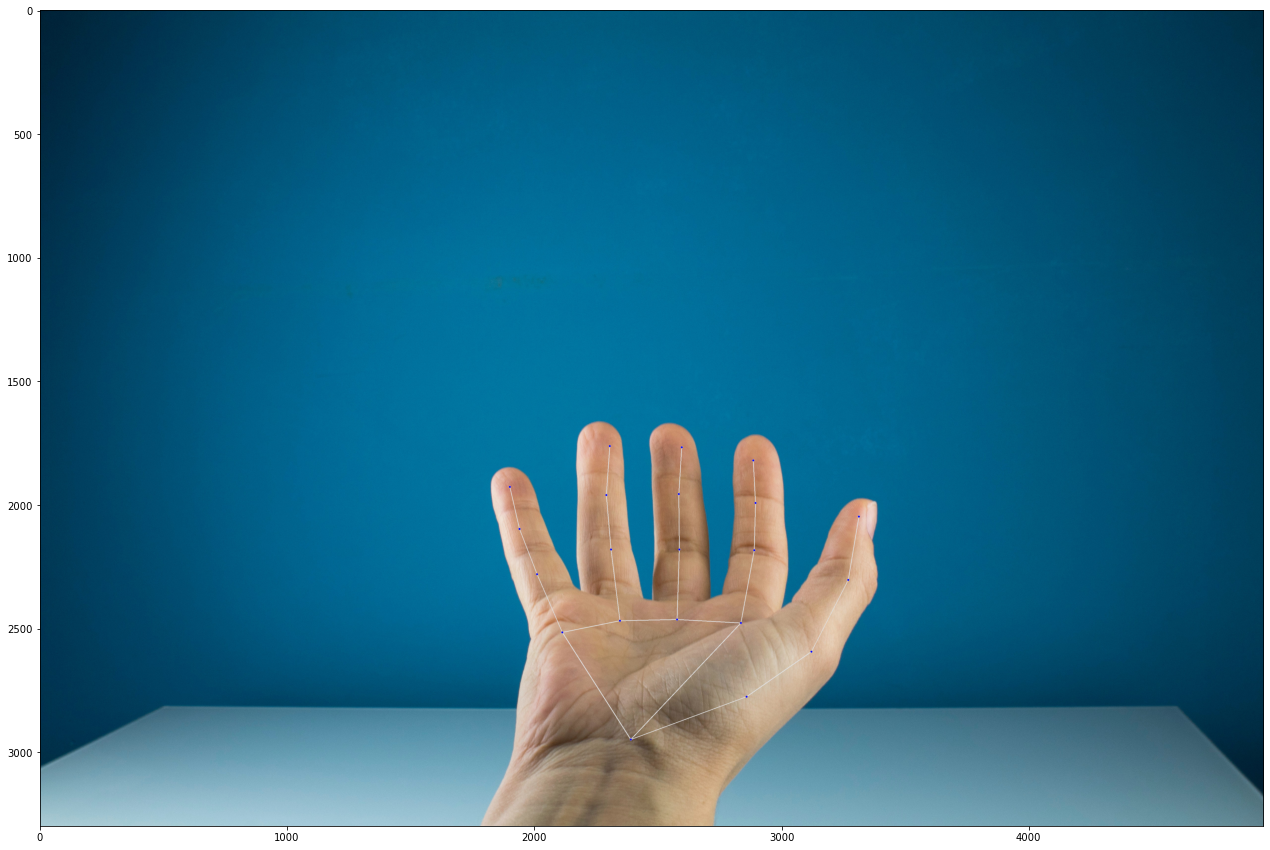

In [6]:
img = detector.findHands(img, draw=True)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hand_lmlist, img_rgb = detector.findHandPosition(img_rgb, hand_num=0, draw=True)
plt.figure(figsize=(50, 15))
plt.imshow(img_rgb)
print(hand_lmlist)


#### The hands keypoints are numbered as follows:

![hand_keypoints](images/hand_landmarks.png)

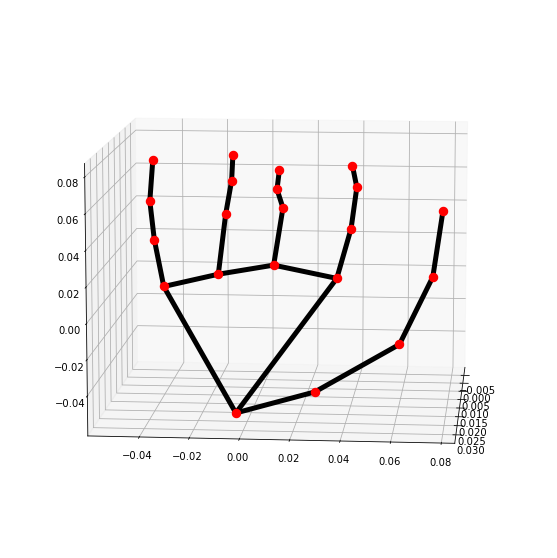

[[0, -0.0030190199613571167, 0.05281462147831917, -0.029684020206332207], [1, 0.029250819236040115, 0.038260892033576965, -0.03164522722363472], [2, 0.06144765764474869, 0.01878734491765499, -0.023125160485506058], [3, 0.0735568255186081, -0.011710437014698982, -0.013356363400816917], [4, 0.07599960267543793, -0.04000721871852875, 0.0003543261846061796], [5, 0.030482139438390732, 0.0012699607759714127, 0.0007320341537706554], [6, 0.0357101634144783, -0.02562856674194336, 0.0047668092884123325], [7, 0.037603262811899185, -0.04874284192919731, 0.00737259304150939], [8, 0.03675420954823494, -0.06476634740829468, 0.002262576948851347], [9, 0.001815555733628571, -0.002649665344506502, 0.005173925310373306], [10, 0.0061501795426011086, -0.037889957427978516, 0.004276343621313572], [11, 0.007137189619243145, -0.05697634816169739, -0.007785975467413664], [12, 0.01203300803899765, -0.07671947032213211, -0.020986082032322884], [13, -0.02079904079437256, -0.0003865733742713928, 0.0004291401128284

In [26]:
hand_3dlmlist = detector.findHand3DPosition(draw=True)
print(hand_3dlmlist)

In [25]:
#some hand keypoints in the image
thumb_mcp_lm = tuple(hand_lmlist[1][1:])
index_finger_mcp_lm = tuple(hand_lmlist[5][1:])
middle_finger_mcp_lm = tuple(hand_lmlist[9][1:])
ring_finger_mcp_lm = tuple(hand_lmlist[13][1:])
pinky_mcp_lm = tuple(hand_lmlist[17][1:])
wrist_lm = tuple(hand_lmlist[0][1:])

#some 3d estimated position in world space coordinates
thumb_mcp_3dlm = tuple(hand_3dlmlist[1][1:])
index_finger_mcp_3dlm = tuple(hand_3dlmlist[5][1:])
middle_finger_mcp_lm = tuple(hand_3dlmlist[9][1:])
ring_finger_mcp_lm = tuple(hand_3dlmlist[13][1:])
pinky_mcp_3dlm = tuple(hand_3dlmlist[17][1:])
wrist_3dlm = tuple(hand_3dlmlist[0][1:])

In [27]:
for i, lm3d in enumerate(hand_3dlmlist):
    hand_3dlmlist[i] = [i, lm3d[1:][0]
                        * 100, lm3d[1:][1] * 100, lm3d[1:][2] * 100]
print(hand_3dlmlist)


[[0, -0.30190199613571167, 5.281462147831917, -2.9684020206332207], [1, 2.9250819236040115, 3.8260892033576965, -3.164522722363472], [2, 6.144765764474869, 1.8787344917654991, -2.3125160485506058], [3, 7.355682551860809, -1.1710437014698982, -1.3356363400816917], [4, 7.599960267543793, -4.000721871852875, 0.03543261846061796], [5, 3.048213943839073, 0.12699607759714127, 0.07320341537706554], [6, 3.57101634144783, -2.562856674194336, 0.47668092884123325], [7, 3.7603262811899185, -4.874284192919731, 0.737259304150939], [8, 3.675420954823494, -6.476634740829468, 0.2262576948851347], [9, 0.1815555733628571, -0.2649665344506502, 0.5173925310373306], [10, 0.6150179542601109, -3.7889957427978516, 0.4276343621313572], [11, 0.7137189619243145, -5.697634816169739, -0.7785975467413664], [12, 1.203300803899765, -7.671947032213211, -2.0986082032322884], [13, -2.079904079437256, -0.03865733742713928, 0.04291401128284633], [14, -1.7747953534126282, -3.591887652873993, 0.11254274286329746], [15, -1.38

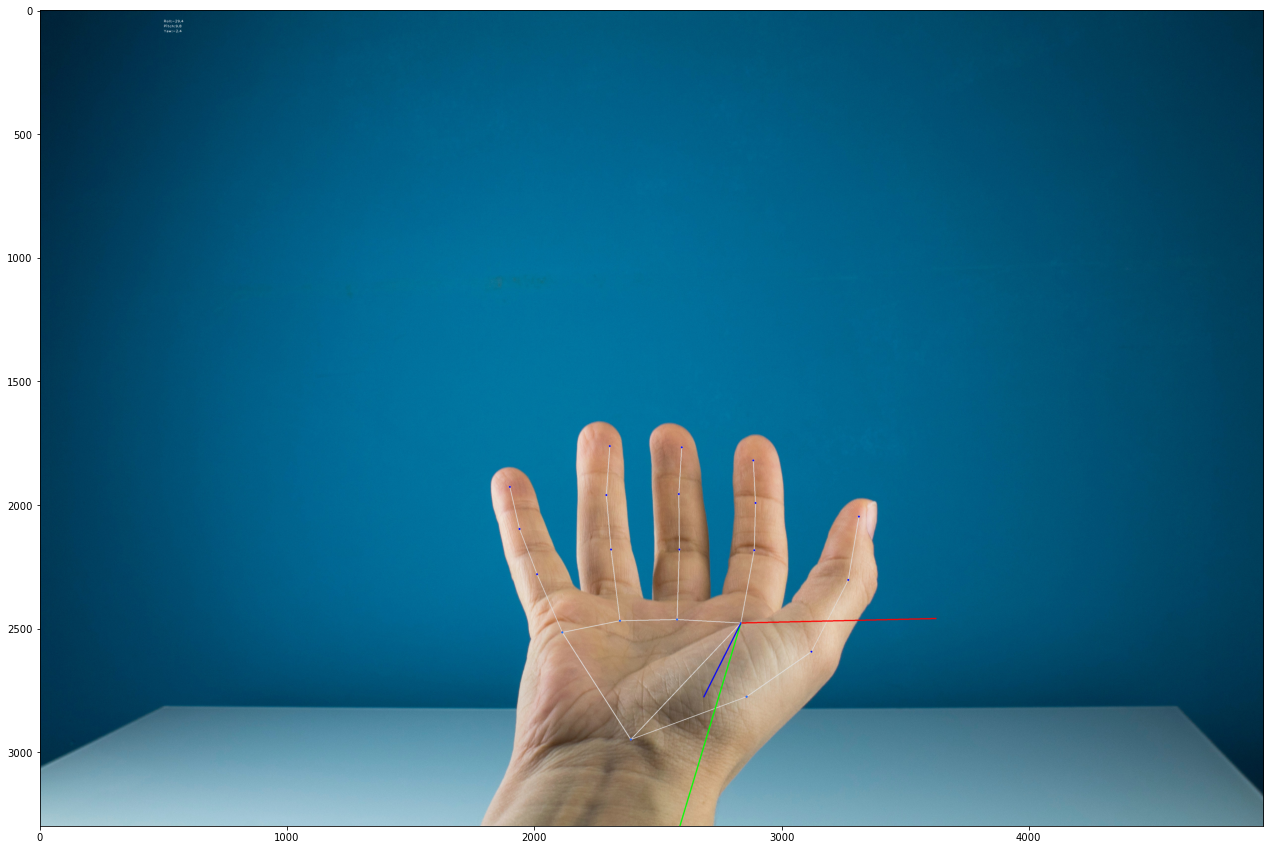

In [10]:

frame, yaw, pitch, roll  = detector.findHandPose(lm3dlist=hand_3dlmlist, lmlist=hand_lmlist, frame = img_rgb, axis_scale=0.1)
plt.figure(figsize=(50, 15))
plt.imshow(frame)

#TO DO: fix pose estimation of hand
